In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scinterp
from sklearn.cluster import KMeans
from distmesh import *
from FEM_TPT import *
import scipy
import csv

# personal libraries
import helpers as helpers

## Load Trajectory, Diffusions, Free Energy

In [2]:
# Load Trajectory
fname = "LJ7_traj.npz"
inData = np.load(fname)
data = inData["data"]
print(f"Shape of trajectory data:{data.shape}")
N = data.shape[1]
print(f"Number of data points:{N}")

# Load Diffusions
fname = "LJ7_traj_diffusions.npz"
inData = np.load(fname)
diffusions = inData["diffusions"]
print(f"Shape of diffusion data:{diffusions.shape}")

# Load Free Energy
fname = "LJ7_free_energy_grid.npz"
inData = np.load(fname)
free_energy = inData["free_energy"]
nx = inData["nx"]
ny = inData["ny"]
xmin = inData["xmin"]
xmax = inData["xmax"]
ymin = inData["ymin"]
ymax = inData["ymax"]
print(f"Shape of free energy data:{free_energy.shape}")
print(f"nx:{nx}")
print(f"ny:{ny}")
print(f"xmin:{xmin}")
print(f"xmax:{xmax}")
print(f"ymin:{ymin}")
print(f"ymax:{ymax}")

# Load Smoothed Free Energy
fname = "LJ7_free_energy_grid_smoothed.npz"
inData = np.load(fname)
free_energy_smoothed = inData["free_energy"]


Shape of trajectory data:(2, 10000)
Number of data points:10000
Shape of diffusion data:(10000, 2, 2)
Shape of free energy data:(401, 201)
nx:201
ny:401
xmin:0.2
xmax:1.2
ymin:-0.5
ymax:1.7


## Plot Trajectory

(-0.5, 1.7)

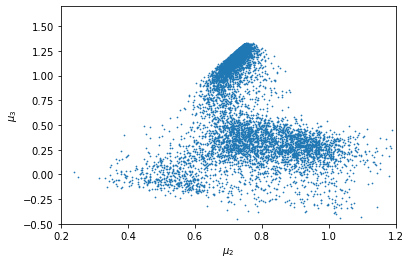

In [3]:
fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.5)
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])


# Plot Diffusion Tensors

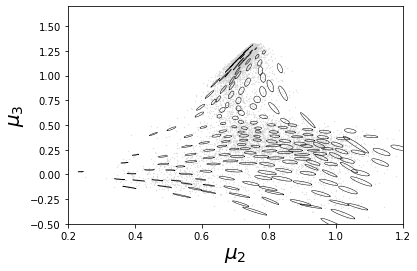

In [4]:
# Cluster data points for better visualization
n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters, random_state=10).fit(data.T)
    
# Plot sampling of diffusion tensors
fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.1, c='lightgray')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\mu_2$', size=20)
plt.ylabel(r'$\mu_3$', size=20)
for i in range(n_clusters):
    idx = np.argmin(np.sum((data.T - kmeans.cluster_centers_[i,:])**2,axis=1))
    C = diffusions[idx, :, :]
    helpers.plot_cov_ellipse(C, data[:, idx], plot_scale=0.01)
plt.show()



## Plot Free Energy

Text(0.5, 1.0, 'Smoothed Free Energy')

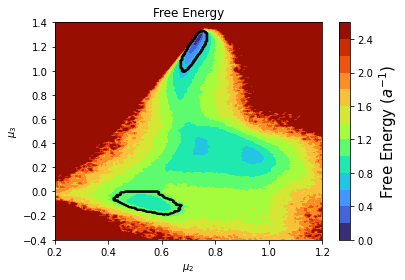

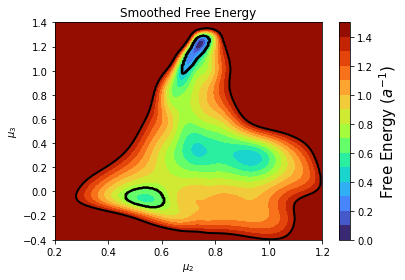

In [7]:
#############################################
# Plotting free energy
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(x, y)

plt.figure()
plt.contourf(xx, yy, free_energy, levels=15, cmap='turbo')
cbar = plt.colorbar()
cbar.set_label(r'Free Energy ($a^{-1}$)', size=15)

# Plot A set, B set
A = np.logical_and(free_energy < 1.1, yy < 0)
B = free_energy < 0.7
plt.contour(xx, yy, A, levels=1, linewidths=2, colors='k')
plt.contour(xx, yy, B, levels=1, linewidths=2, colors='k')

plt.xlim([0.2, 1.2])
plt.ylim([-0.4, 1.4])
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')
plt.title("Free Energy")

#############################################
# Plotting smoothed free energy
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(x, y)

plt.figure()
plt.contourf(xx, yy, free_energy_smoothed, levels=15, cmap='turbo')
cbar = plt.colorbar()
cbar.set_label(r'Free Energy ($a^{-1}$)', size=15)

# Plot A set, B set
A = np.logical_and(free_energy_smoothed < 0.7, yy < 0.07)
B = free_energy_smoothed < 0.4

cA = plt.contour(xx, yy, A, levels=1, linewidths=2, colors='k')
cB = plt.contour(xx, yy, B, levels=1, linewidths=2, colors='k')
c_outer = plt.contour(xx, yy, free_energy_smoothed, [1.4], linewidths=2, colors='k')
plt.xlim([0.2, 1.2])
plt.ylim([-0.4, 1.4])
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')
plt.title("Smoothed Free Energy")


In [6]:
h = 0.01
for item in cA.collections:
    for i in item.get_paths():
        pA = i.vertices
pA = reparametrization(pA,h)
for item in cB.collections:
    for i in item.get_paths():
        pB = i.vertices
pB = reparametrization(pB,h)

for item in c_outer.collections:
    for i in item.get_paths():
        p_outer = i.vertices
p_outer = reparametrization(p_outer,h)


In [8]:
with open('LJ7_pts_outer_bdry_smooth.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(p_outer)
with open('LJ7_pts_A_bdry_smooth.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(pA)  
with open('LJ7_pts_B_bdry_smooth.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(pB)        

12369
22624
168
272


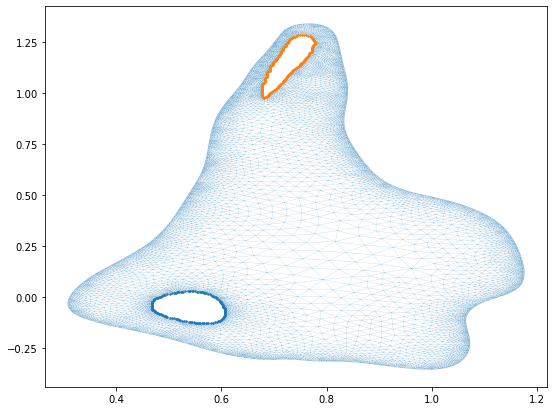

In [9]:
# download triangular mesh
pts = np.loadtxt('LJ7_pts_smooth.csv', delimiter=',', dtype=float)
tri = np.loadtxt('LJ7_tri_smooth.csv', delimiter=',', dtype=int)
Npts = np.size(pts,axis = 0)
Ntri = np.size(tri,axis = 0)
print(Npts)
print(Ntri)
# download indices of mesh points at the boundaries of A and B
Aind = np.loadtxt('LJ7_Abdry_smooth.csv', delimiter=',', dtype=int) # find mesh points on \partial A
NAind = np.size(Aind)
print(NAind)
Bind = np.loadtxt('LJ7_Bbdry_smooth.csv', delimiter=',', dtype=int)  # find mesh points on \partial B
NBind = np.size(Bind)
print(NBind)

fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.triplot(pts[:,0],pts[:,1],tri,linewidth=0.1)
plt.scatter(pts[Aind,0],pts[Aind,1],s = 2)
plt.scatter(pts[Bind,0],pts[Bind,1],s = 2)
plt.savefig('LJ72D_trimesh_smooth.pdf')


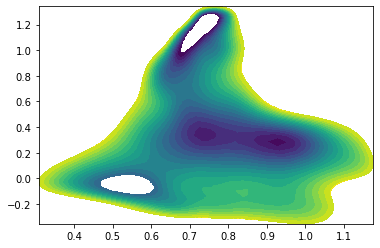

In [11]:
# interpolate the free enegry from the regular grid onto the mesh points
FE = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(free_energy_smoothed)) #, method = "linear",bounds_error=False, fill_value = 1.8)
Fpts = FE(pts)
plt.tricontourf(pts[:,0], pts[:,1],tri,Fpts,np.arange(0.4,1.4,0.05) )

In [12]:
# interpolate entries of the diffusion matrix onto the mesh points
print(np.shape(data))
print(np.shape(diffusions[:,0,0]))
M11grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,0,0],(xx,yy),method = 'linear')
M12grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,0,1],(xx,yy),method = 'linear')
M22grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,1,1],(xx,yy),method = 'linear')

(2, 10000)
(10000,)


0  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values
657  points with nan or inf values
657  points with nan or inf values
657  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values


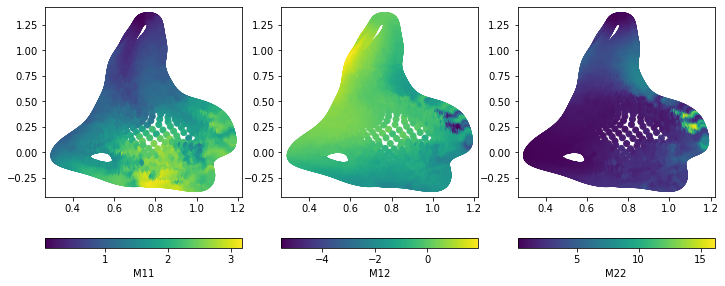

In [13]:
def check_inf_nan(arr):
    ind_bad = np.argwhere(np.isnan(arr))
    print(np.size(ind_bad)," points with nan or inf values")
    return ind_bad

ind_bad = check_inf_nan(diffusions[:,0,0])
ind_bad = check_inf_nan(diffusions[:,0,1])
ind_bad = check_inf_nan(diffusions[:,1,1])


M11fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M11grid))
M12fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M12grid))
M22fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M22grid))
M11pts = M11fun(pts)
M12pts = M12fun(pts)
M22pts = M22fun(pts)

ind_bad = check_inf_nan(M11pts)
M11fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,0,0])
M11pts[ind_bad] = M11fun_NN(pts[ind_bad,:])

ind_bad = check_inf_nan(M12pts)
M12fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,0,1])
M12pts[ind_bad] = M12fun_NN(pts[ind_bad,:])

ind_bad = check_inf_nan(M22pts)
M22fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,1,1])
M22pts[ind_bad] = M22fun_NN(pts[ind_bad,:])

fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.subplot(1,3,1)
plt.scatter(pts[:,0], pts[:,1],c = M11pts)
plt.colorbar(label="M11", orientation="horizontal")
ind_bad = check_inf_nan(M11pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.subplot(1,3,2)
plt.scatter(pts[:,0], pts[:,1],c = M12pts)
plt.colorbar(label="M12", orientation="horizontal")
ind_bad = check_inf_nan(M12pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.subplot(1,3,3)
plt.scatter(pts[:,0], pts[:,1],c = M22pts)
plt.colorbar(label="M22", orientation="horizontal")
ind_bad = check_inf_nan(M22pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.savefig('LJ72D_Mmatrix_smooth.pdf')


In [14]:
# find the committor
beta = 5
q = FEM_committor_solver(pts,tri,Aind,Bind,Fpts,M11pts,M12pts,M22pts,beta)

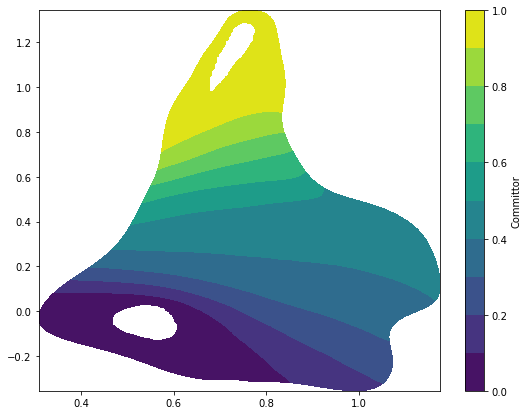

In [15]:
# visualize the committor
fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
plt.colorbar(label="Committor", orientation="vertical")
# axes=plt.gca()
# axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig('LJ72D_committor_smooth.pdf')

In [16]:
# find the reactive current and the transition rate
Rcurrent, Rrate = reactive_current_and_transition_rate(pts,tri,Fpts,M11pts,M12pts,M22pts,beta,q)
print("Transition rate = ",Rrate)

Transition rate =  0.15376439291091143


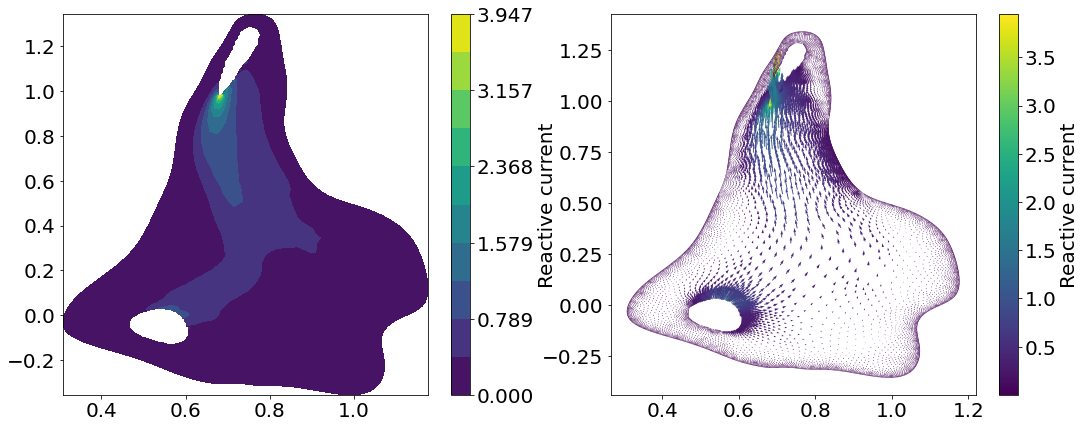

In [17]:
# visualize the reactive current
# find the absolute value of the reactive current
ARcurrent = np.linalg.norm(Rcurrent,axis = 1)
ARCmax = np.amax(ARcurrent)
fig = plt.gcf()
fig.set_size_inches(18, 7)
plt.subplot(1,2,1)
plt.tricontourf(pts[:,0], pts[:,1],tri,ARcurrent,np.linspace(0,ARCmax,11))
plt.colorbar(label="Reactive current", orientation="vertical")
# axes=plt.gca()
# axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
#plt.savefig('LJ7_rcurrent.pdf')
#plt.show()
plt.subplot(1,2,2)
plt.quiver(pts[:,0],pts[:,1],Rcurrent[:,0],Rcurrent[:,1],ARcurrent)
plt.colorbar(label="Reactive current", orientation="vertical")
# axes=plt.gca()
# axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig('LJ7_rcurrent_smooth.pdf')

In [18]:
# save the mesh point, the committor, and the reactive current
TPTdata = np.concatenate((pts,np.reshape(q,(Npts,1)),Rcurrent),axis = 1)
with open('LJ7_TPTdata_smooth.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(TPTdata)

(94, 2)
94


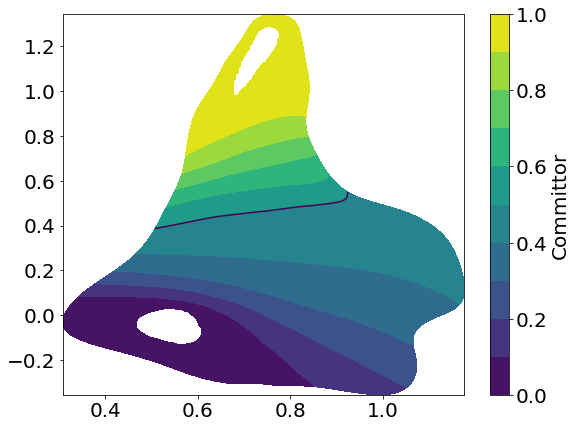

In [20]:
# committor analysis
fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
plt.colorbar(label="Committor", orientation="vertical")
c05 = plt.tricontour(pts[:,0], pts[:,1],tri,q, [0.5])
for item in c05.collections:
    for i in item.get_paths():
        p05 = i.vertices
p05 = reparametrization(p05,5e-3)        
print(np.shape(p05))
Nq05 = np.size(p05,axis = 0)
print(Nq05)

In [ ]:
Ntraj = 200 # trajectories per point
h = 0.0005 # timestep
sigma = np.sqrt(2*h/beta) # standard deviation
MeanForce_pts = mean_force(pts,tri,Fpts)
MF1 = scipy.interpolate.NearestNDInterpolator(pts, MeanForce_pts[:,0])
MF2 = scipy.interpolate.NearestNDInterpolator(pts, MeanForce_pts[:,1])
Va = 1.0
Vb = 0.7

# x_vec = np.reshape(xx,(nx*ny,1))
# y_vec = np.reshape(yy,(nx*ny,1))
# fe_vec = np.reshape(free_energy,(nx*ny,1))
# xy = np.concatenate((x_vec,y_vec),axis = 1)

# FE_NN = scipy.interpolate.NearestNDInterpolator(xy,fe_vec) #, method = "linear",bounds_error=False, fill_value = 1.8)